# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of a traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

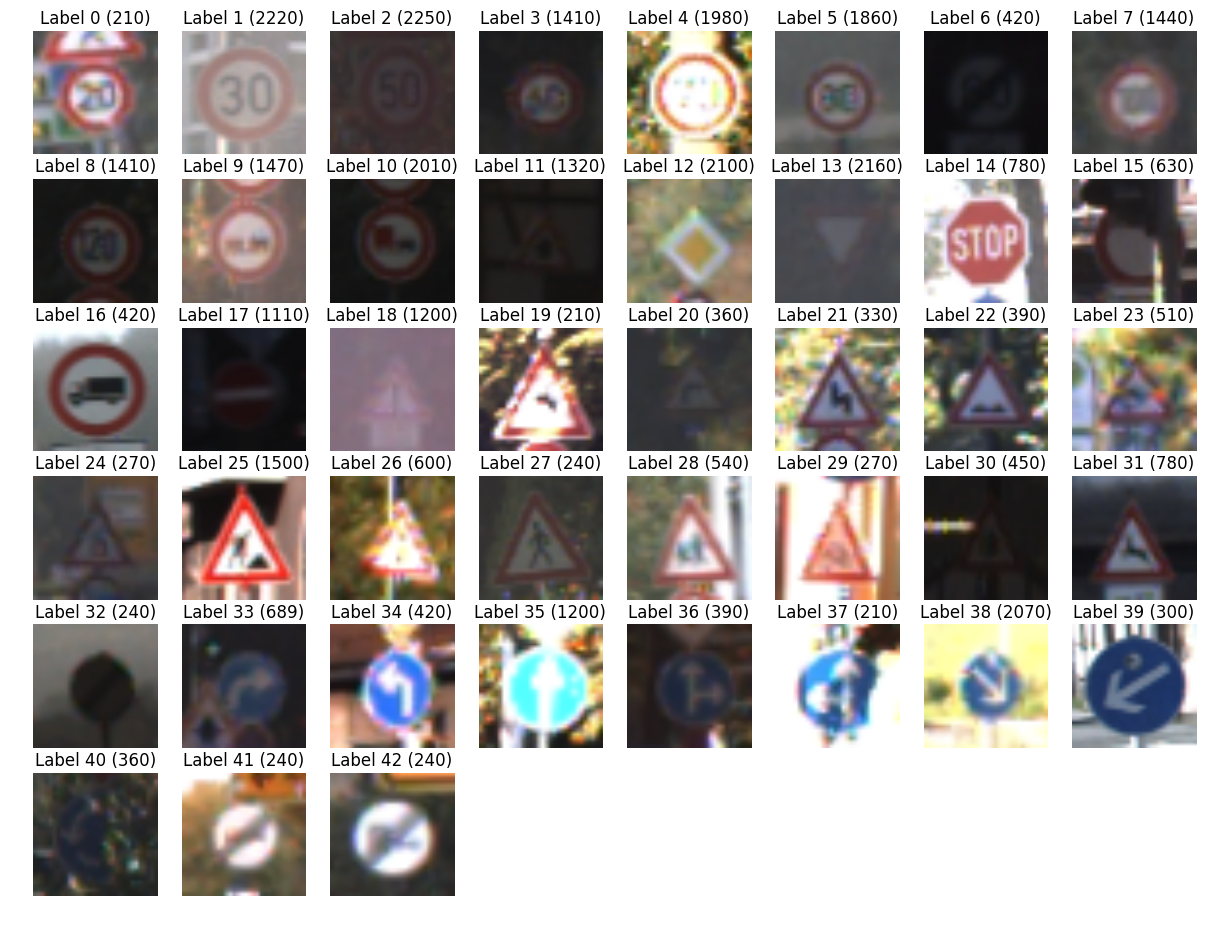

Execution time: 3.945 seconds


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import time
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images_and_labels(images, labels):
    """Display the images of the dataset as well as the labels.
    
    parameters:
        - images: is a numpy array of images.
        - labels: is a list with labels.
        
    Code adapted from waleedka @ github.
    """
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]

        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()
    return

t0 = time.time()
display_images_and_labels(X_train, y_train.tolist())
t1 = time.time()
print("Execution time: {0:.3f} seconds".format(t1-t0))

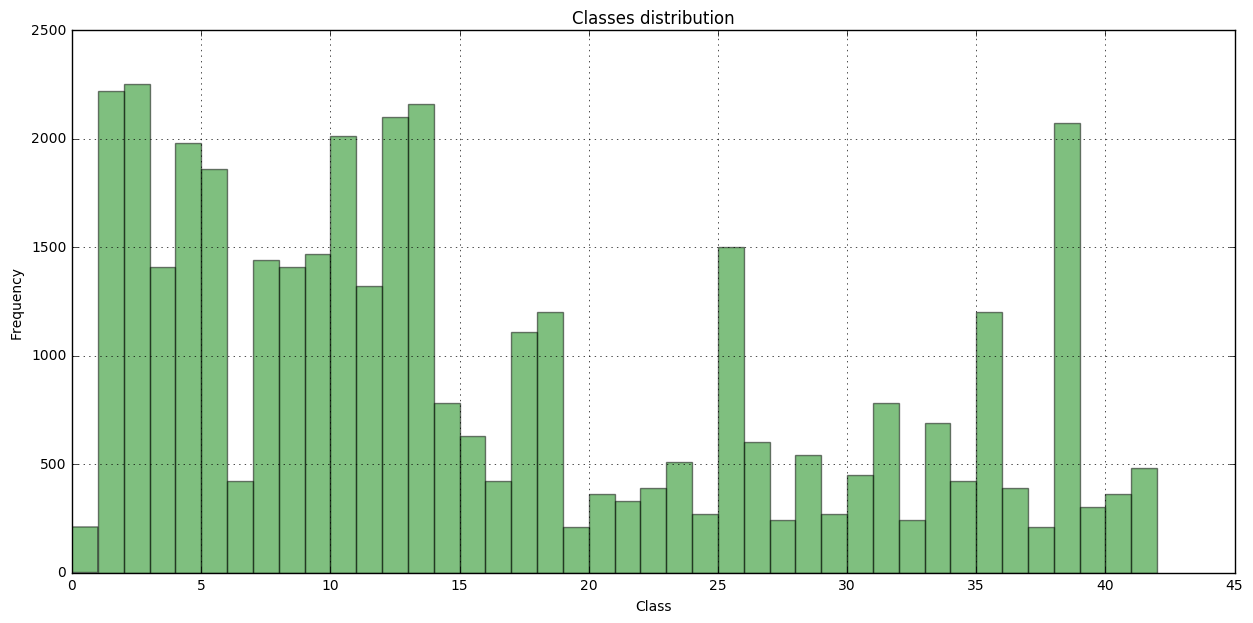

In [4]:
# Display the classes distribution
def display_class_hist(labels, labels_count):
    plt.figure(figsize=(15, 7))
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Classes distribution")
    plt.hist(labels, labels_count-1, facecolor='green', alpha=0.5)
    plt.grid(True)
    plt.show()

display_class_hist(y_train, n_classes)

## Dataset Analysis

At a first glance, the histogram above depicts a not well uniformed distribution of the traffic sign images. Some signs, _"speed limit 30, 50, 70 and 80"_ as well as _"No passing for vehicles over 3.5 metric tons"_ and _"Priority road"_ are present in the dataset with a very high frequency (more than 2000 images for each class). On the contrary, the _"speed limit 20"_ and the _"Go straight or left"_ signs have a fairly limited frequency (less than 250).

A nice TODO for this project is either using **augmentation** to generate more images of the signs whose frequency is really low or **collecting** more pictures of those signs.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Some usefull import
import tensorflow as tf
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Apply [-1:+1] normalization to input data.
train_norm = (X_train - 128.0) / 128.0
test_norm  = (X_test  - 128.0) / 128.0

In [7]:
### Verify that the data has been scaled to [-1:+1]

print("MAX before train normalization = {0}".format(np.amax(X_train)))
print("MIN before train normalization = {0}".format(np.amin(X_train)))
print("MAX after train normalization  = {0:.3}".format(np.amax(train_norm)))
print("MIN after train normalization  = {0:.3}".format(np.amin(train_norm)))
print()
print("MAX before test normalization = {0}".format(np.amax(X_test)))
print("MIN before test normalization = {0}".format(np.amin(X_test)))
print("MAX after test normalization  = {0:.3}".format(np.amax(test_norm)))
print("MIN after test normalization  = {0:.3}".format(np.amin(test_norm)))

MAX before train normalization = 255
MIN before train normalization = 0
MAX after train normalization  = 0.992
MIN after train normalization  = -1.0

MAX before test normalization = 255
MIN before test normalization = 0
MAX after test normalization  = 0.992
MIN after test normalization  = -1.0


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I applied a simple **normalization** to the input data which scaled the `X_train` and `X_test` values from `[0:255]` to `[-1.0:+1.0]` interval.

This technique makes the training faster and reduces the chances of getting stuck in local optima during the optimization phase ([reference](http://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network)).

In [21]:
### Generate data additional data (OPTIONAL!)
## TODO: Augmentation or Collect more images????

### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Split the training set into 80% training and 20% validation
X_train_norm, X_valid_norm, y_train_norm, y_valid_norm = train_test_split(train_norm, y_train, test_size=0.2)

### Use the pickle X_test, y_test as test set.

In [9]:
### Verify the correctness of train/validation split.

dataset_size = train_norm.shape[0]
train_size = X_train_norm.shape[0]
validation_size = X_valid_norm.shape[0]
test_size = X_test.shape[0]

print("Entire dataset size: {0} ({1:.0f}%)".format(dataset_size, 100*dataset_size/dataset_size))
print("Train set size: {0} ({1:.0f}%)".format(train_size, 100*train_size/dataset_size))
print("Validation set size: {0} ({1:.0f}%)".format(validation_size, 100*validation_size/dataset_size))
print("Test set size: {0}".format(test_size))

Entire dataset size: 39209 (100%)
Train set size: 31367 (80%)
Validation set size: 7842 (20%)
Test set size: 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

**Training, Validation and Test Sets**

I decided to extract a validation set from the training set. In particular, I split the training set into two parts: the former (80% of the whole training set) will be used as **training set**, the latter (20% of the whole training set) will be used as **validation test**.

Regarding the **test set**, instead, I decided to use the set offered by the pickle dictionary `X_test`.

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # We need a 5x5 filter with stride of 1 and VALID padding.
    w_1    = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    b_1    = tf.Variable(tf.zeros(6))
    conv_1 = tf.nn.conv2d(x, w_1, strides=[1, 1, 1, 1], padding='VALID') + b_1

    # Activation.
    conv_1 = tf.nn.relu(conv_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    w_2    = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b_2    = tf.Variable(tf.zeros(16))
    conv_2 = tf.nn.conv2d(conv_1, w_2, strides=[1, 1, 1, 1], padding='VALID') + b_2

    # Activation.
    conv_2 = tf.nn.relu(conv_2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400 = 5x5x16.
    fc0    = flatten(conv_2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w_fc1  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b_fc1  = tf.Variable(tf.zeros(120))
    fc1    = tf.matmul(fc0, w_fc1) + b_fc1

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w_fc2  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b_fc2  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, w_fc2) + b_fc2
    
    # Activation.
    fc2  = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w_fc3  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b_fc3  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, w_fc3) + b_fc3

    return logits

In [11]:
### Placeholders for input and output.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [12]:
### Training pipeline and Hyperparameters.
rate       = 0.001
EPOCHS     = 15
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
### Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The network architecture used to classify traffic signs is the [LeNet-5](http://yann.lecun.com/exdb/lenet/).

The image below depicts the neural network.

![LeNet Architecture](lenet.png)

As can be seen from the image, the neural network consists of:

  * 1 x **Input Layer**
  * 6 x **Hidden Layers**
  * 1 x **Output Layer**
  
The table provides a summary of each layer.

| Layer        | Type            | Size      | Filter Size   | Filter Stride | Padding |
|:------------:|:---------------:|:---------:|:-------------:|:-------------:|:-------:|
| **Input**    | -               | 32x32x3   | -             | -             | -       |
| **Hidden 1** | Convolutional   | 28x28x6   | 5x5           | 1             | `Valid` |
| **Hidden 2** | Max Pooling     | 14x14x6   | 2x2           | 2             | `Valid` |
| **Hidden 3** | Convolutional   | 10x10x16  | 5x5           | 1             | `Valid` |
| **Hidden 4** | Max Pooling     | 5x5x6     | 2x2           | 2             | `Valid` |
| **Hidden 5** | Fully Connected | 120       | -             | -             | -       |
| **Hidden 6** | Fully Connected | 84        | -             | -             | -       |
| **Output**   | Fully Connected | 43        | -             | -             | -       |

Finally, in the entire architecture I used the ReLu function as activation for all the layers.

In [14]:
### Train your model here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    t0 = time.time()
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train_norm)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_norm, y_train_norm = shuffle(X_train_norm, y_train_norm)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm[offset:end], y_train_norm[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid_norm, y_valid_norm)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    t1 = time.time()
    print("Training time: {:.3f}".format(t1-t0))
    print()

    ### Save the model
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet_nallo')
    print("Model saved")
    
    ### Run the model against the test set
    test_accuracy = evaluate(test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.770

EPOCH 2 ...
Validation Accuracy = 0.908

EPOCH 3 ...
Validation Accuracy = 0.934

EPOCH 4 ...
Validation Accuracy = 0.946

EPOCH 5 ...
Validation Accuracy = 0.963

EPOCH 6 ...
Validation Accuracy = 0.966

EPOCH 7 ...
Validation Accuracy = 0.973

EPOCH 8 ...
Validation Accuracy = 0.972

EPOCH 9 ...
Validation Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.980

EPOCH 11 ...
Validation Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.975

EPOCH 13 ...
Validation Accuracy = 0.973

EPOCH 14 ...
Validation Accuracy = 0.975

EPOCH 15 ...
Validation Accuracy = 0.983

Training time: 383.252

Model saved
Test Accuracy = 0.913


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The LeNet model was trained by applying the [Adam Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) to the loss function.

The loss function is defined as follows:

$$loss = \frac{\sum_{i}(CrossEntropy(SoftMax(wX_i+b), Logits_i))}{N}$$

The table below lists the other hyperparameter values

| Hyperparameter    | Value       |
|:-----------------:|:-----------:|
| `Learning Rate`   | `0.001`     |
| `EPOCHS`          | `15`        |
| `BATCH_SIZE`      | `128`       |
| `weights - mu`    | `0`         |
| `weights - sigma` | `0.1`       |

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

This is my first ever project that focuses on implementing a Convolutional Neural Network using TensorFlow.
After following the Udacity lectures of the Self Driving Car nano degree program I decided to adopt an **incremental approach** in coming up with the solution to the traffic sign classifier.

I firstly read [articles](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) as well as
[online blog posts](https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.h88up8u8b)
that describe feasible NN architectures for image recognition and I came to the conclusion that a Convolution Neural Network - CNN was a good starting point. Therefore, I decided to re-use and adapt the LeNet-5 architecture of the Self Driving Car nano degree program to the new dataset.

The main changes from the original architecture touched the NN input and output sizes which currently are respectively 32x32x3 and 43 instead of 32x32x1 and 10 (MNIST dataset). Personally, I think that the trickiest part in implementing a CNN is computing the convolution filters size in such a way to obtain the desired output. Fortunately, the following formula helped me significantly:

$$w' = 1 + \frac{(w - w_f + 2 * padding)}{stride}$$

$$h' = 1 + \frac{(h - h_f + 2 * padding)}{stride}$$

where:

  * $w$ is the width of the input layer
  * $w'$ is the width of the output layer
  * $w_f$ is the width of the filter
  * $h$ is the height of the input layer
  * $h'$ is the height of the output layer
  * $h_f$ is the height of the filter
  
The first run of the LeNet model (10 epochs, 0.001 learning rate) gave me accuracy on the validation set of 95%.
I therefore decided to normalize the input by scaling the values to the $[-1;+1]$ interval. That was a good decision because the accuracy rose from 95% to 97.7%.

The next step I followed was increasing the training epochs from 10 to 15 without changing the learning rate and this brought me accuracy on the validation of 98.3% (91.4% on test set). Increasing even further the epochs number does not lead to better results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import csv
import cv2
import os

def load_label_names(filename):
    """Read the .csv file with the label names.
    
    returns:
        A dict with (key:val) mapped to (id:name)
    """
    d = {}
    with open(filename) as f:
        csv_reader = csv.reader(f)
        pairs = [(int(r[0]),r[1]) for r in csv_reader if r[0]!='ClassId']
        d = dict(pairs)

    return d

def load_and_scale_images(folder):
    """Load and scale the new images to be 32x32x3"""
    image_names = os.listdir(folder)
    image_names.remove('.DS_Store')
    bgr_images = [cv2.imread(folder + "/" + name) for name in image_names]
    rgb_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in bgr_images]
    resized_images = [cv2.resize(img, (32, 32)) for img in rgb_images]
    return np.array(resized_images)

def display_new_images(images):
    plt.figure(figsize=(15, 15))
    i = 1
    for image in images:
        plt.subplot(8, 8, i)
        plt.axis('off')
        plt.title("Sample #{0}".format(i))
        plt.imshow(image)
        i += 1

    plt.show()
    return

Loaded 43 label names.
Loaded 24 images of size (32, 32, 3).



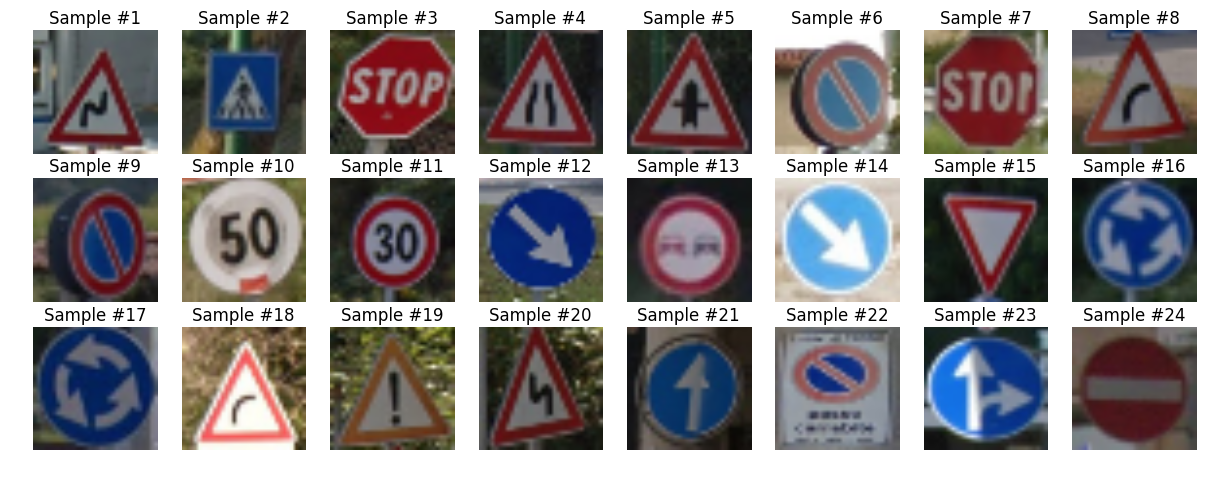

In [16]:
# Load the label names
label_names_dict = load_label_names('signnames.csv')

# Load the new scaled images
images = load_and_scale_images("new-images")

# Assign the labels, -1 means not in training set.
images_labels = np.array([21, -1, 14, 24, 11, -1, 14, 20,
                          -1, 2, 1, 38, 9, 38, 13, 40,
                          40, 20, 18, 21, 35, -1, 36, 17])

# Number of images
n_img = images.shape[0]

# Image Shape
img_shape = images.shape[1:]

print("Loaded {0} label names.".format(len(label_names_dict)))
print("Loaded {0} images of size {1}.".format(n_img, img_shape))
print()

display_new_images(images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

**Samples #1 and #20:**

These two images represent the same basic concept (Double Curve) but they are the opposite of each other. It would be interesting to figure out if the classifier is labelling them with the correct label. If, for any reason, the classifier does not apply the correct label to both the signals it means that it has started to learn image patterns in too much in detail.

**Sample #4:**

This image sign does not show up in the training set therefore, the classifier may find it hard to label it. What could possibly happen is that all of the 43 Softmax probabilities are set to low values. This would be helpful because it would mean that the sign couldn't be labelled.

**Samples #6, #9 and #22:**

These signs represent the No Waiting signal which is not present in the dataset. It would be interesting to know whether the classifier applies a given label to that sign. What could possibly happen is that all of the 43 Softmax probabilities are set to low values.

**Sample #10:**

This speed limit 50 km/h may be challenging to classify because of its white border. However, I would expect that the classifier labels it correctly because the input data is normalized and has therefore partially lost the concept of colour.

In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet_nallo.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored")

    predictions = sess.run(logits, feed_dict={x: images})
    labels = np.argmax(predictions, axis=1)
    
    new_test_accuracy = evaluate(images, images_labels)
    print("Accuracy on the new images = {:.3f}".format(new_test_accuracy))

Model restored
Accuracy on the new images = 0.542


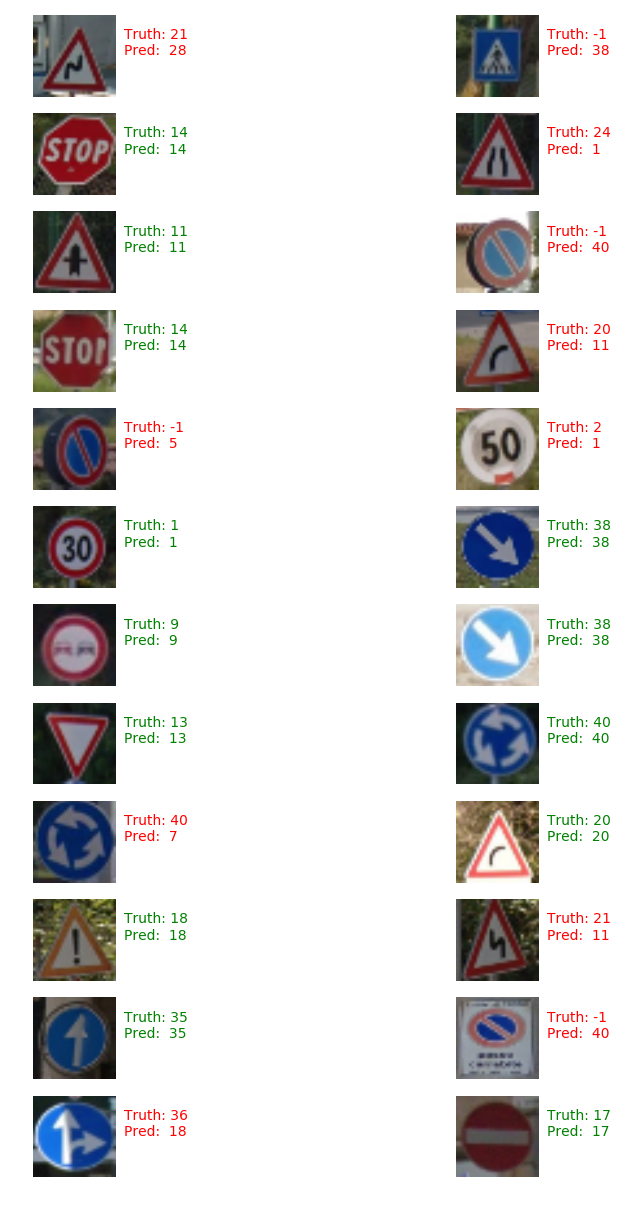

In [19]:
# Display the predictions and the ground truth visually.

fig = plt.figure(figsize=(10, 15))
for i in range(len(predictions)):
    truth = images_labels[i]
    prediction = labels[i]
    plt.subplot(12, 2, 1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(35, 15, "Truth: {0}\nPred:  {1}".format(truth, prediction), 
             fontsize=10, color=color)
    plt.imshow(images[i])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Let's start by reporting the accuracy of the model when run against the captured images: 45.8%.
Not very encouraging at a first glance, but let's dig a little bit in the result.

The model correctly classified 11 out of 24 images (45.8%). Among the 24 images, 4 of them are not present in the training set therefore, the classifier is not able to assign a correct label to them. If we remove those 4 images the model accuracy raise to 55% that is to say 11 correct labels out of 20.

I am now going to report why, in my opinion, the model misclassified some images.

Firstly, if we have a look at what type of images the model misclassified we can notice that the classes with incorrect labels have only a few hundred training samples compared to the few thousand for the other classes therefore, a good choice would be collecting more training samples, in particular, of signs whose occurrence in the dataset is below 1000

Secondly, the noise in the test sample images (too much background) may have played a key role in misclassifying those images.

In [20]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

probabilities = tf.placeholder(tf.float32, (None, 43))

with tf.Session() as sess:
    res = sess.run(tf.nn.top_k(tf.nn.softmax(probabilities), k=5), feed_dict={probabilities: predictions})
    print(res)

TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.39595031e-24,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+0

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model showed up an unexpected result. According to the `top_k` probabilities, the model looks like completely certain of its predictions. Even the misclassified images have a probability of 100% to belong to the wrong class.

Given that I am a new in the field of CNN I am wondering if my model is doing something weird under the hood.

## Future work

  * Using another network architecture.
  * Converting images from RGB to YUV space and normalize only the Y channel (see paper)
  * Generating more samples for those classes with less than 1000 occurrences
    * Image shift [-2,2] pixels.
    * Image scale [0.9,1.1].
    * Rotation [-15,+15] degree.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.